In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper



In [4]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")
print(arxiv.name)
print(arxiv.description)

arxiv
Query arxiv papers


In [5]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [6]:
api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wikipedia = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia, description="Query for information retrieval of wikipedia")
print(wikipedia.name)
print(wikipedia.description)

wikipedia
Query for information retrieval of wikipedia


In [8]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [10]:
tavily.invoke("Latest game launches in 2025?")

[{'title': 'Upcoming games 2025: Our release calendar - PC Gamer',
  'url': 'https://www.pcgamer.com/games/new-games-2025-upcoming-pc-release-schedule/',
  'content': "After 2025's rather busy beginnings with new games like Civilization 7, Avowed, and Monster Hunter Wilds, you may be hoping for a breather—and that's too bad. As the year barrels forward, the 2025 games calendar grows longer, fleshing out dates for faraway favorites like Metal Gear in August and Borderlands 4 in September. [...] March 11 — Wanderstop - An existential cozy game (Steam)\nMarch 13 — Midnight Murder Club - Hide and Seek with guns in the dark (Steam)\nMarch 14 — WWE 2K25 - Yearly wrestling returns with new match types (Steam)\nMarch 18 — 33 Immortals - Co-op roguelike with up to 32 friends (Epic)\nMarch 18 — MySims - A once Nintendo exclusive re-released (Steam)\nMarch 20 — Assassin's Creed: Shadows - Feudal Japan assassin era (Epic)\nMarch 20 — Bleach Rebirth of Souls - The story from the beginning (Steam)",

In [11]:
## Combining all the tools in the new list
tools = [arxiv, wikipedia,tavily]

In [13]:
## Initialize the LLM Model
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen-qwq-32b")

In [14]:
llm.invoke("all you need is attention")

AIMessage(content='\n<think>\nOkay, the user typed "all you need is attention." That\'s a well-known quote from the Beatles song "All You Need Is Love," but with "attention" instead. Maybe they\'re referencing it, but I should check the context.\n\nFirst, I should think about what they\'re asking. They might be asking me to explain the quote, or they might be making a statement. Since it\'s just that line, perhaps they want a response related to the song or a deeper meaning about attention versus love.\n\nI should consider if "attention" here is a play on the Beatles\' lyrics. The original is "All You Need Is Love," so changing it to "attention" could imply that attention is the key thing needed in their situation. Maybe they\'re feeling overlooked and need reassurance, or they\'re discussing a topic where attention is crucial.\n\nAlternatively, "attention" could relate to attention mechanisms in machine learning, since I\'m an AI. The user might be referring to the self-attention mech

In [15]:
llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:
## Execute the call
llm_with_tools.invoke("What is the recent news on AI") ##using Tavily api
llm_with_tools.invoke("What is the resarch on AI") ##using Arxiv api
llm_with_tools.invoke("What is Data science") ##using LLM api

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dznw', 'function': {'arguments': '{"query": "recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 197, 'prompt_tokens': 325, 'total_tokens': 522, 'completion_time': 0.492449478, 'prompt_time': 0.056482203, 'queue_time': 1.6640129869999998, 'total_time': 0.548931681}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_512a3da6bb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e19b57df-710f-4e0a-b9fa-7c4db89c5b43-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent news on AI'}, 'id': 'call_dznw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 325, 'output_tokens': 197, 'total_tokens': 522})

## Workflow for managing multiple tasks and tools efficiently

1. Identify tasks and tools required for each task.
2. Prioritize tasks based on urgency and importance.
3. Allocate resources and tools to each task accordingly.
4. Monitor progress and make adjustments as needed to stay on track.
5. Review the completed tasks and evaluate the effectiveness of the tools used.



In [19]:
## State schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ## Human Message or AI message
from typing import Annotated ## Labelling
from langgraph.graph.message import add_messages ## Reducers in Langgraph

In [20]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] ## add_message is Reducers, mean it not overwrite inside llm's message instead it appends new messages to the existing list
    

In [21]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [ ]:
def tools_calling_llm(state:State):
    return{"messages": [llm_with_tools.invoke(state['messages'])]}

# BUild graph
builder = StateGraph(State)
builder.add_node("tools_calling_llm", tools_calling_llm)
builder.add_node("tools", ToolNode(tools))

# adding Edges
builder.add_edge(START, "tools_calling_llm")   
builder.add_conditional_edges(
    "tools_calling_llm",
    ## If the latest message result from assistant is a tool call-> Tool condition routes to tools
    ## If the latest message result from assistant is not a tool call->tools_condition routes to LLM
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View the graph

display(Image(graph.get_graph().draw_mermaid_png()))





ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [34]:
messages= graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_6c95)
 Call ID: call_6c95
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [35]:
messages= graph.invoke({"messages":"Hello I am Akkshay"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello I am Akkshay
================================== Ai Message ==================================

Hello Akkshay! Welcome! How can I assist you today? 😊


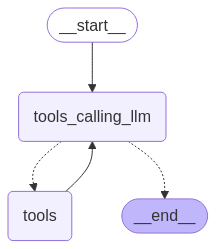

In [37]:
def tools_calling_llm(state:State):
    return{"messages": [llm_with_tools.invoke(state['messages'])]}

# BUild graph
builder = StateGraph(State)
builder.add_node("tools_calling_llm", tools_calling_llm)
builder.add_node("tools", ToolNode(tools))

# adding Edges
builder.add_edge(START, "tools_calling_llm")   
builder.add_conditional_edges(
    "tools_calling_llm",
    ## If the latest message result from assistant is a tool call-> Tool condition routes to tools
    ## If the latest message result from assistant is not a tool call->tools_condition routes to LLM
    tools_condition,
)
builder.add_edge("tools", "tools_calling_llm")

graph = builder.compile()

# View the graph

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
messages= graph.invoke({"messages":"Hello I am Akkshay, Give me the latest AI news, and also latest ai research paper"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello I am Akkshay, Give me the latest AI news, and also latest ai research paper
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_9vwq)
 Call ID: call_9vwq
  Args:
    query: latest AI news
  arxiv (call_bzrm)
 Call ID: call_bzrm
  Args:
    query: latest AI research papers
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest AI News, Analysis & Events", "url": "https://www.artificialintelligence-news.com/", "content": "Artificial Intelligence, Companies, Deep & Reinforcement Learning, Development\nMarch 6, 2025\nDeepSeek-R1 reasoning models rival OpenAI in performance\nArtificial Intelligence, Companies, Deep & Reinforcement Learning, Development\nJanuary 20, 2025\nNew AI training techniques aim to overcome current challenges\nDeep & Re